# Mañcheno (2022) and [Mendez and Losada (2004)](https://www.sciencedirect.com/science/article/abs/pii/S0378383903001182)

Under linear wave theory, the conservation of energy equation for a wave approaching a coastline normally, with a bathymetry that has straight, parallel contours
$$ \frac{\partial Ec_g}{\partial x} = - \epsilon_v - \epsilon_n $$
where:
* $E=\frac{1}{8}\rho q H^2$ is the energy density
* $H$ is the wave height
* $c = \sqrt{(g/k) \tanh(kh)}$, is the wave celerity
* $c_g$ is the wave group velocity
* $\sigma$ is the wave angular frequency, $n=\frac{1}{2}\left(1 + \frac{2kh}{\sinh 2kh} \right)$
* $f_p$ average frequency corresponding to the wave period
* $k$ is the wave number

_"The correct calculation of the force $F_x$ should take into account the relative motion between the fluid and the plant and both inertial and drag forces, considering a huge amount of geometrical and biomechanical parameters."_  <br> The $\epsilon_v$ used here neglects plant motion, this is justified over the two papers.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [10]:
# numerical model parameters
dx = 1e-3

# empirical constants
γ = 0.6  # Mendez and Losada (2004)
B = 1    # Mendez and Losada (2004)

# climate parameters (need to review freq. and wave number)
h = np.arange(2, 0.5, -dx)  # bathymetry
Tp = 3.5                    # peak wave period (s)
fp = 1 / Tp                 # peak frequency (s-1)
sigmap = 2 * np.pi * fp    
# wave angular frequency - CHECK
L = 60                      # minimum wind wavelength: https://en.wikipedia.org/wiki/Wind_wave - CHECK
kp = 2 * np.pi / L          # wave number associated to peak wave period (m-1) - CHECK
cdw = 0.4                   # drag coefficient
hm0 = 0.6                   # significant wave height (m)


global g, rho
g = 9.81
rho = 997 # density of water (kg/m3)

## Plot the dissipation functions over the bathymetry

In [11]:
# dissipation functions
def breaking_dissipation(h, fp, hrms, B=1, γ=0.6):
    """Mendez and Losada (2004) equation (34)."""
    g = 9.81
    rho = 997  
    eb = (3 * np.sqrt(np.pi) / 16)
    eb *= (rho * g)
    eb *= (B**3 * fp) / (γ**4 * h**5)
    eb *= hrms**7
    return eb


def veg_dissipation(hv, h, cdw, bv, nv, kp, sigma_p, hrms):
    """Mendez and Losada (2004) equation (35).
    
    'Assuming negligible plant motion, that the wave-driven flow can be defined
    using linear wave theory, and that waves are irregular and follow a Rayleigh
    distribution.'
    
    Unsure about sigma_p.
    
    Parameters:
    ----------
    hv : float
        Vegetation height (m)
    """
    g = 9.81
    rho = 997  # density of water (kg/m3)
    
    ev = 1 / (2 * np.sqrt(np.pi))
    ev *= rho * cdw * bv * nv
    ev *= ((kp * g) / (2 * sigma_p))**3
    
    nom = np.sinh(kp * hv)**3 + (3 * np.sinh(kp * hv))
    denom = 3 * kp * np.cosh(kp * h)
    
    ev *= (nom / denom) * hrms**3
    
    return ev

def energy_density(H, h, k):
    """Find source."""
    rho = 997
    g = 9.81
    cg = 0.5 * np.sqrt(np.tanh(k * h) / (g * k))
    e = 0.125 * rho * g * H**2
    return e * cg

def wave_height_from_ecg(ecg, h, k):
    """Find source."""
    rho = 997
    g = 9.81
    cg = 0.5 * np.sqrt(np.tanh(k * h) / (g * k))
    return np.sqrt((8 * ecg) / (rho * g * cg))


def forward_euler(ecg, dx, hv, h, cdw, bv, nv, kp, hrms, fp, sigmap):
    ev = veg_dissipation(hv, h, cdw, bv, nv, kp, sigmap, hrms)
    eb = breaking_dissipation(h, fp, hrms)
    return ecg - dx * (eb + ev)

# implicit Euler

Vegetation height 0.2


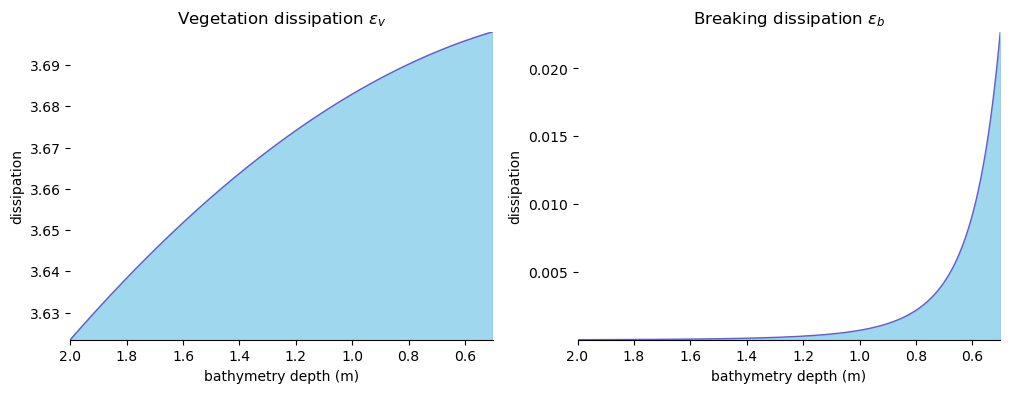

In [49]:
# calculate dissipation rates
bv = 0.030 # mean stem width (m)
nv = 944   # plants per m2
hv = 0.2
hrms = 0.1  # just made this up 
veg_dissip = []
breaking_dissip = []

for i, ih in enumerate(h):
    breaking_dissip.append(breaking_dissipation(ih, fp, hrms))
    veg_dissip.append(veg_dissipation(hv, ih, cdw, bv, nv, kp, fp, hrms))
                      
                      
# plot the results
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(h, veg_dissip, linewidth=1, color='slateblue')
axs[1].plot(h, breaking_dissip, linewidth=1, color='slateblue')
axs[0].fill_between(h, veg_dissip, linewidth=1, color='skyblue', alpha=0.8)
axs[1].fill_between(h, breaking_dissip, linewidth=1, color='skyblue', alpha=0.8)

axs[0].set_ylim([min(veg_dissip), max(veg_dissip)])
axs[1].set_ylim([min(breaking_dissip), max(breaking_dissip)])

axs[0].set_title(r'Vegetation dissipation $\epsilon_v$')
axs[1].set_title(r'Breaking dissipation $\epsilon_b$')

for ax in axs:
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ax.set_xlabel('bathymetry depth (m)')
    ax.set_ylabel('dissipation')
    ax.set_xlim([h[0], h[-1]])
    
print(f"Vegetation height {hv}")

## Wave energy balance equation

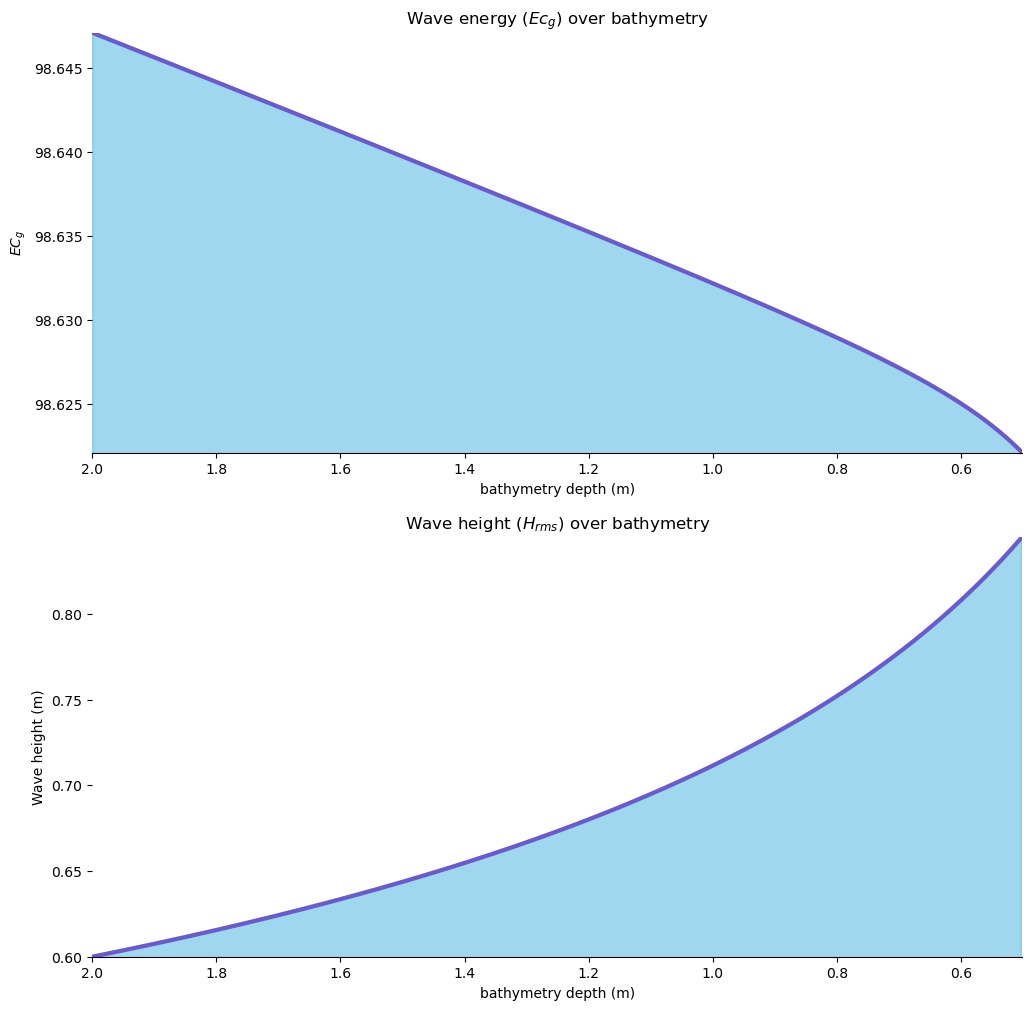

In [94]:
# vegetation parameters (salt marshes 3.2.1.1) S1
hv = 0.2   # average vegetation height (m)
nv = 944   # plants per m2
bv = 0.030 # mean stem width (m)

# starting wave energy
ecg = energy_density(hm0, h[0], kp)

h = np.arange(2, 0.5, -dx)  # bathymetry
# h[100:] *= .5

ecgs = []
wave_heights = []
for i, ih in enumerate(h):
    ecgs.append(ecg)
    wave_heights.append(wave_height_from_ecg(ecg, ih, kp))
    ecg = forward_euler(ecg, dx, hv, ih, cdw, bv, nv, kp, hrms, fp, sigmap)
    
# plot the results
fig, axs = plt.subplots(2, 1, figsize=(12, 12))

# E * cg
axs[0].plot(h, ecgs, linewidth=3, color='slateblue')
axs[0].fill_between(h, ecgs, linewidth=3, color='skyblue', alpha=0.8)
axs[0].set_ylim([min(ecgs), max(ecgs)])
axs[0].set_title(r'Wave energy ($Ec_g$) over bathymetry')
axs[0].set_ylabel(r'$EC_g$')

# Root mean-squared wave height
axs[1].plot(h, wave_heights, linewidth=3, color='slateblue')
axs[1].fill_between(h, wave_heights, linewidth=3, color='skyblue', alpha=0.8)
axs[1].set_ylim([min(wave_heights), max(wave_heights)])
axs[1].set_title(r'Wave height ($H_{rms}$) over bathymetry')
axs[1].set_ylabel('Wave height (m)')


for ax in axs:
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.set_xlabel('bathymetry depth (m)')
    ax.ticklabel_format(useOffset=False)
    ax.set_xlim([h[0], h[-1]]);


# Mangrove wave dissipation with age

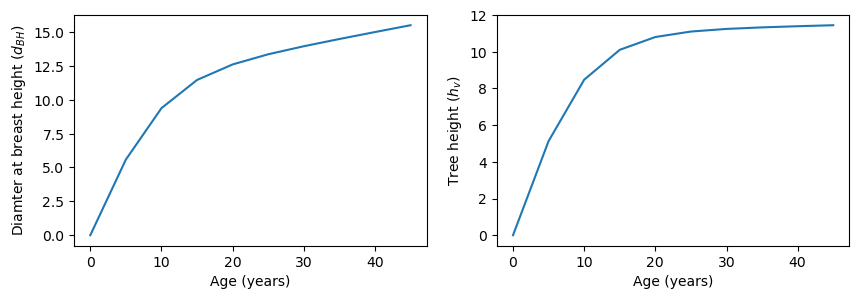

In [148]:
age = np.arange(0, 50, 5)

def hv(age, loc=10, slope=0.01, scale=11):
    """Tree height (guess from Fig 2.2)."""
    return scale * np.tanh(age / loc) + slope * age # tree height (guess from Fig 2.2)

def dBH(age, loc=10, slope=0.1, scale=11):
    """Tree diameter at breast height (guess from Fig 2.2)."""
    return scale * np.tanh(age / loc) + slope * age # tree height (guess from Fig 2.2)
    

fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax[0].plot(age, dBH(age))
ax[1].plot(age, hv(age))

ax[0].set_ylabel(r'Diamter at breast height ($d_{BH}$)')
ax[1].set_ylabel(r'Tree height ($h_v}$)')
ax[0].set_xlabel('Age (years)')
ax[1].set_xlabel('Age (years)');

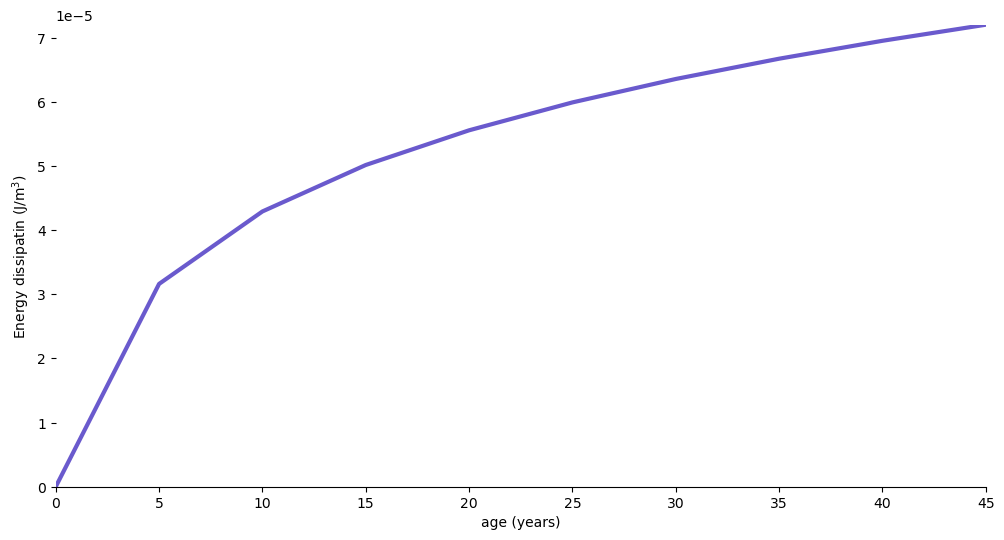

In [133]:
# 4.2 mangroves over time
hm0 = 2
ih = 5
cdw = 1
nv = 0.1


hroot = lambda hv: 0.04 * hv


trunk_dissip = []
canopy_dissip = []
root_dissip = []

for i, iage in enumerate(age):
    ihv = trunk_height(iage)
    
    
    
    dissipation = veg_dissipation(ihv, ih, cdw, bv, nv, kp, sigmap, hrms)
    dissipations.append(dissipation)
    
# plot the results
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ax.plot(age, dissipations, linewidth=3, color='slateblue', label='Trunk')
# ax.fill_between(age, dissipations, linewidth=3, color='skyblue', alpha=0.8)
ax.set_ylim([min(dissipations), max(dissipations)])
ax.set_ylabel(r'Energy dissipatin (J/m$^3$)')

ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xlabel('age (years)')
ax.ticklabel_format(useOffset=False)
ax.set_xlim([age[0], age[-1]]);